In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

# Read endogenous and exogenous data and filter country/dates

In [20]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [21]:
# We filter the country, dates and the variable to predict

country = 'France'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '30-06-2020' 

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Making the data a daily series and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
#covid_ctry_var = covid_ctry_var.resample('D').sum()
covid_ctry_varR = covid_ctry_var.rolling(7).mean().dropna()

In [22]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [23]:
# We now need to filter the country/dates, and aply 7-day rolling mean:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
exogenous_ctry = exogenous_ctry.loc[initialdate:enddate]

# We apply the 7-day rolling mean, as in the endogenous data
exogenous_ctryR = exogenous_ctry.rolling(7).mean().dropna()

In [24]:
# We check that the only NaNs removed are the 6 positions created by the 7-rolling mean
print(len(covid_ctry_varR) == len(covid_ctry_var) - 6)
print(len(exogenous_ctryR) == len(exogenous_ctry) - 6)

True
True


# Visualize endogenous and exogenous data and normalize it all

(176,) (176, 13)


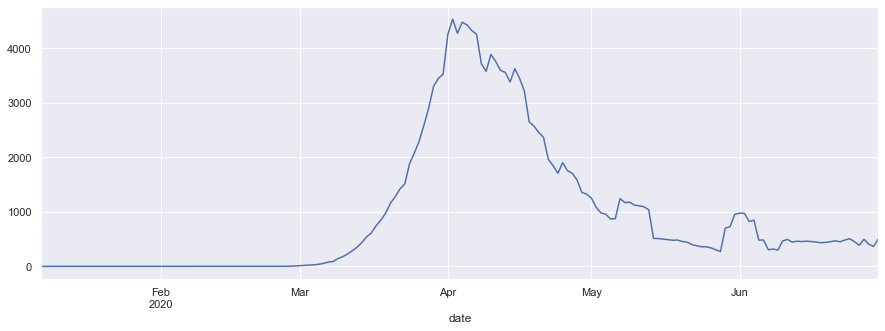

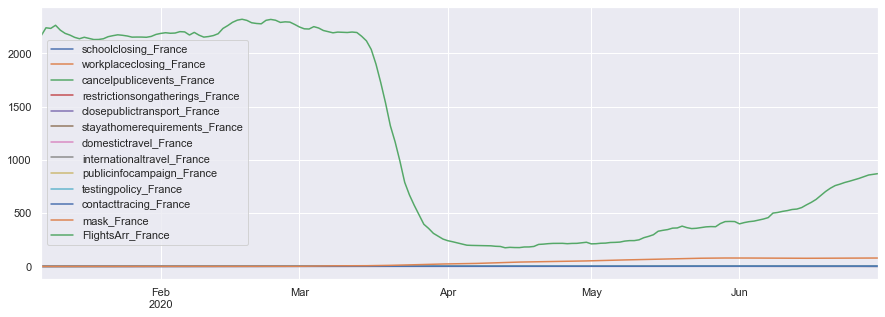

In [25]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [26]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [27]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaled_output.resample('1D').sum()

(176,) (176, 13)


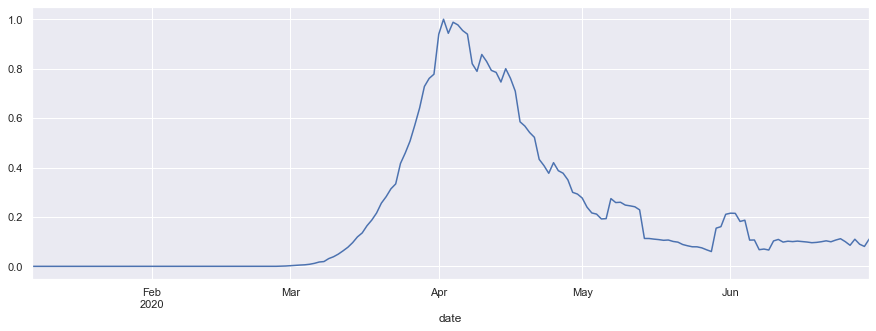

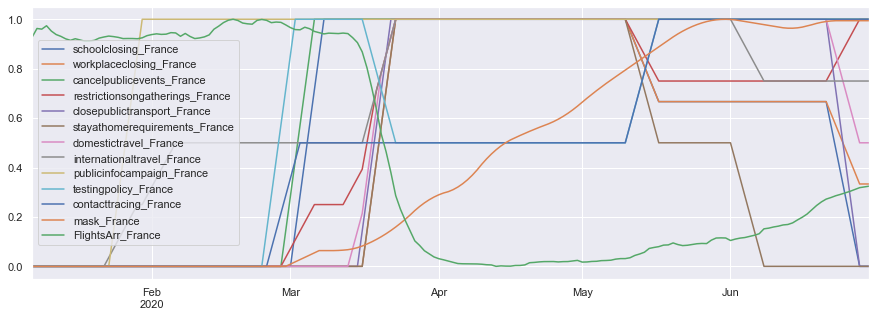

In [28]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [29]:
# We are going to use 90% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.90)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [30]:
train_size, test_size

(158, 18)

# Stationarity: estimate differencing term (d)

In [31]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


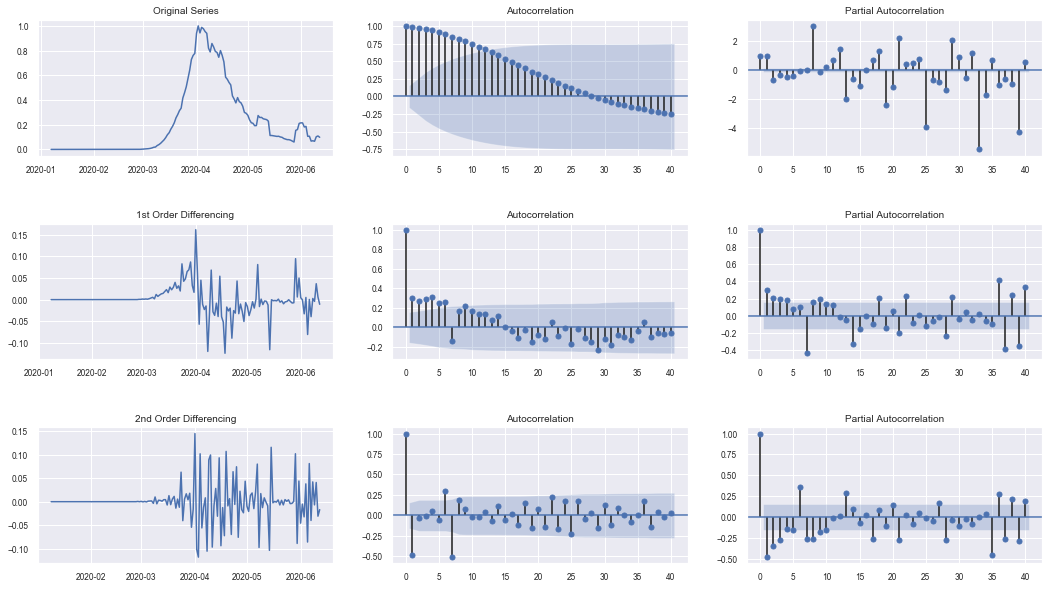

In [32]:
# Plotting ACF and PACF with the different 'd' values from previous step

plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)

# Original Series
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().dropna(), lags=40, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().dropna(), lags=40, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 2])
plt.show()
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

In [33]:
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

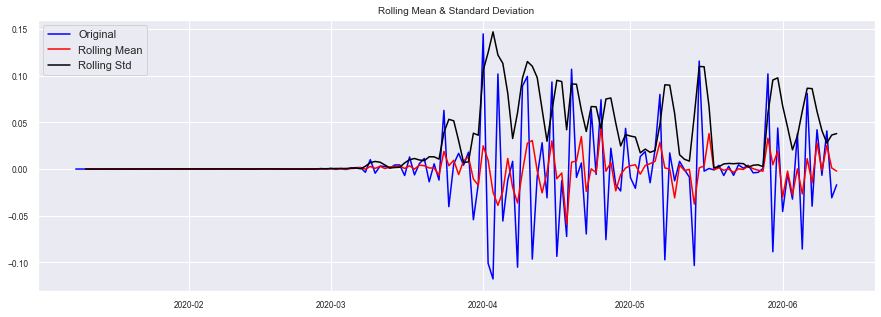

Result of Dicky=Fuller Test
Test Statistic           -3.382945
p-value                   0.011554
#Lags Used               12.000000
#Observations Used      143.000000
Critical Value (1%)      -3.476927
Critical Value (5%)      -2.881973
Critical Value (10%)     -2.577665
dtype: float64


In [35]:
test_stationarity(y_train.diff().diff().dropna())

# Estimate order p and q of ARIMA model, using auto_arima

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-617.476, BIC=-565.520, Time=0.606 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-614.315, BIC=-568.471, Time=0.551 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-614.165, BIC=-565.265, Time=0.591 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-613.849, BIC=-564.950, Time=0.668 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-615.401, BIC=-572.613, Time=0.501 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-489.451, BIC=-434.438, Time=0.836 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-612.500, BIC=-557.488, Time=0.706 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-612.752, BIC=-560.796, Time=0.673 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-613.523, BIC=-561.566, Time=0.615 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-595.285, BIC=-537.216, Time=0.734 seconds
Total fit time: 6.494 seconds
      

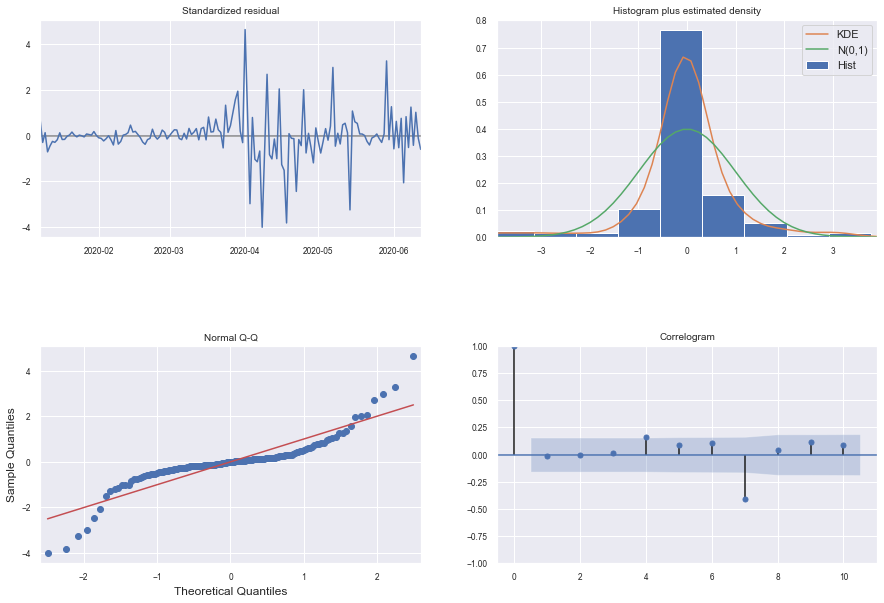

In [42]:
modelauto7 = pm.auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                    #  test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto7.summary())
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

# Train and fit SARIMAX model with previous selected (p,d,q) orders

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 427.685
Date:                Thu, 13 Aug 2020   AIC                           -817.370
Time:                        16:28:57   BIC                           -759.181
Sample:                    01-07-2020   HQIC                          -793.738
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_Sweden               -0.2190      0.183     -1.199      0.231      -0.577       0.139
workplaceclosing_Sweden            -0.0284      0.123     -0.231    

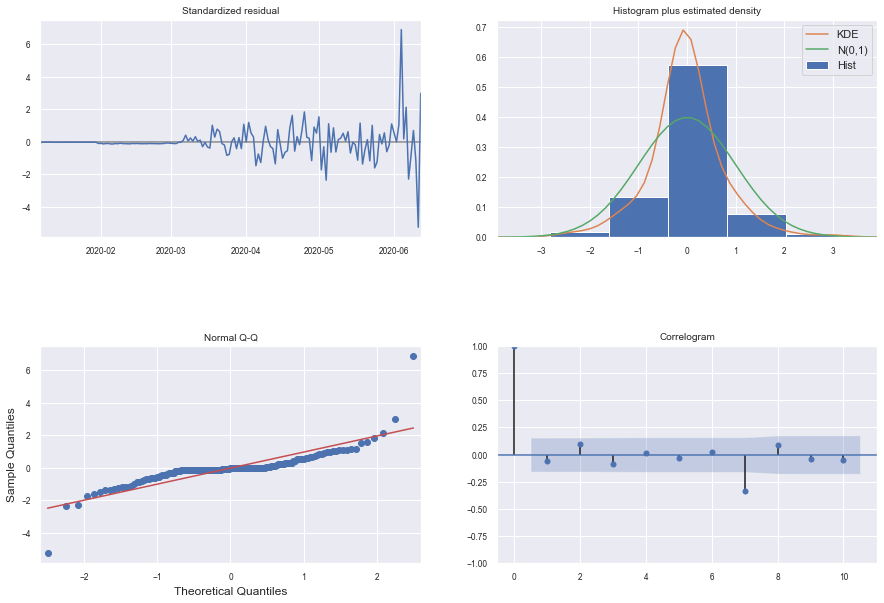

In [32]:
model1 = sm.tsa.statespace.SARIMAX(y_train, order=(1,0,4), exog=X_train)
results1 = model1.fit()
print(results1.summary())
results1.plot_diagnostics(figsize=(15,10));

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 416.344
Date:                Thu, 13 Aug 2020   AIC                           -794.688
Time:                        16:29:41   BIC                           -736.619
Sample:                    01-07-2020   HQIC                          -771.104
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_Sweden               -0.1497      0.153     -0.978      0.328      -0.450       0.150
workplaceclosing_Sweden            -0.0215      0.110     -0.196    

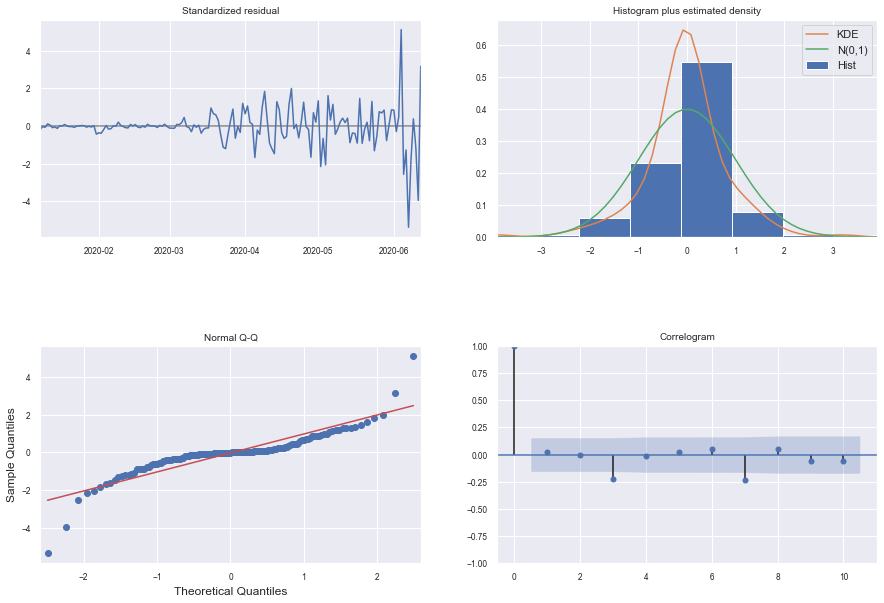

In [33]:
model2 = sm.tsa.statespace.SARIMAX(y_train, order=(1,1,4), exog=X_train)
results2 = model2.fit()
print(results2.summary())
results2.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model RMSE

In [34]:
train_size, test_size, X_test.shape

(158, 18, (18, 13))

In [41]:
# Generate in-sample predictions (train) and evaluate RMSE:

in_predictions = results2.predict(exog=X_train)

print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(y_train, in_predictions)))

Train RMSE: 0.017


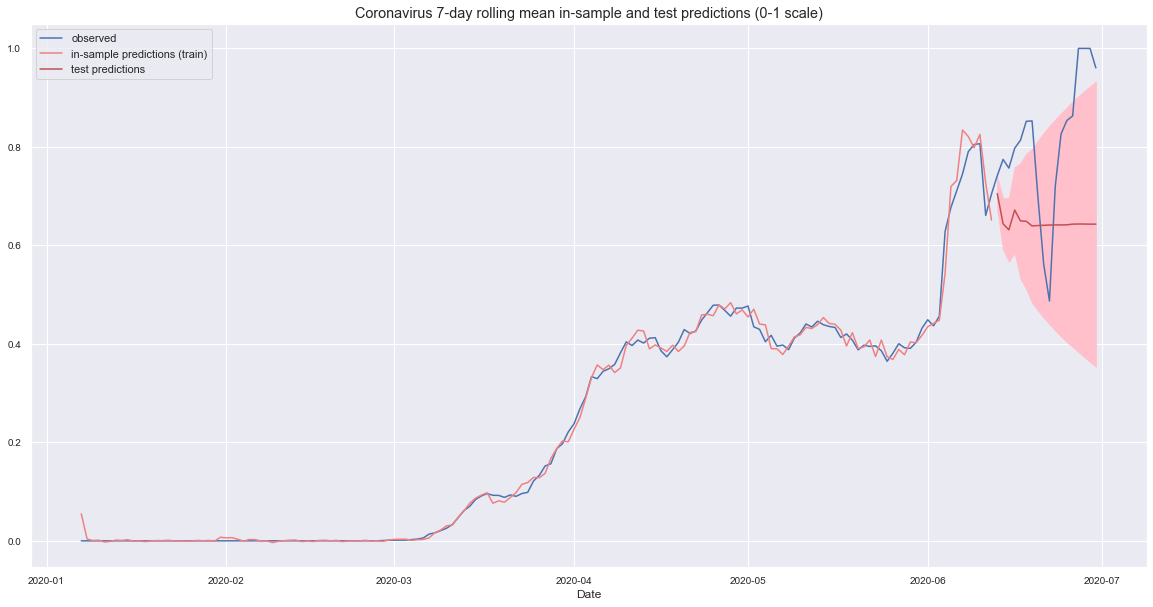

In [42]:
# Generate forecast for the test sample, updating our model by simulating days passing with our test set:

#def forecast_one_step(i):
#    forecast = results2.get_forecast(steps=1, exog=X_test.iloc[i].values.reshape(1,-1))
#    fc = forecast.predicted_mean
#    conf_int = forecast.conf_int()
#    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

#forecasts = []
#confidence_intervals = []
#i = 0

#for new_ob in y_test:
#    fc, conf = forecast_one_step(i)
#    forecasts.append(fc)
#    confidence_intervals.append(conf)

    # Update the existing model
#    results2.append(new_ob, exog=X_test.iloc[i].values.reshape(1,-1))
#    i = i+1


# Generate forecast for the test sample
#one_step_forecast = results2.get_prediction(start=train_size, end=train_size+test_size-1, exog=X_test)
one_step_forecast = results2.get_forecast(steps=test_size, exog=X_test)


# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
#print(mean_predict.values)

# plot the data
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'figure.figsize':(20,10), 'xtick.labelsize':'small', 'ytick.labelsize':'small', 'axes.titlesize':'large'})
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train)
plt.plot(in_predictions.index, in_predictions, color='lightcoral', label= 'in-sample predictions (train)')

# plot mean predictions (test)
plt.plot(mean_forecast.index, mean_forecast, color='r', label='test predictions')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.legend()
plt.show()

In [43]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y[train_size:], mean_forecast.values)))

Test RMSE: 0.213


# Scale data back to original values

In [44]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.name)

In [45]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.name)

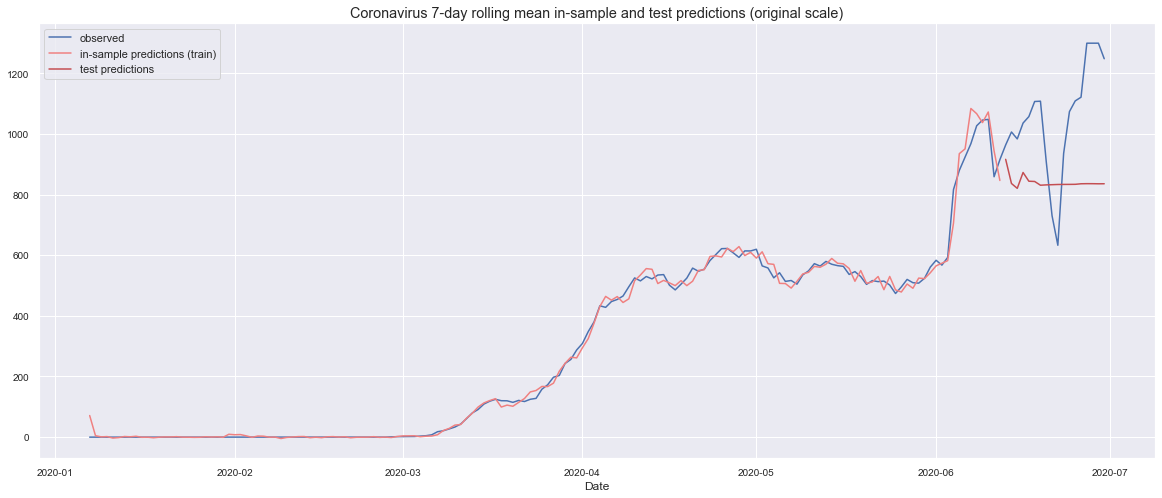

In [46]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [47]:
print("Test RMSE (original scale): %.3f" % np.sqrt(mean_squared_error(covid_ctry_varR[train_size:], testPredictS)))

Test RMSE (original scale): 276.074


# Save model so we can then update with future values

In [28]:
%pwd

'C:\\Users\\marta\\Documents\\MasterDataScience\\project\\KSchool-Master-Final-Project'

In [48]:
# Set model name
filename = './SwedenSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(results2, filename)

['./SwedenSARIMAXmodel2.pkl']

In [49]:
# Load the model back in
loaded_model = joblib.load(filename)

# Update the model
#loaded_model.update(__dfnew___)

In [50]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  158
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 416.344
Date:                Thu, 13 Aug 2020   AIC                           -794.688
Time:                        16:35:39   BIC                           -736.619
Sample:                    01-07-2020   HQIC                          -771.104
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_Sweden               -0.1497      0.153     -0.978      0.328      -0.450       0.150
workplaceclosing_Sweden            -0.0215      0.110     -0.196      0.844      -0.236       0.193
cancelpublicevents_Sweden           0.0327      0.105      0.313      0.754      -0.172       0.238
restrictionsongatherings_Sweden     0.1455      0.242      0.602      0.547      -0.328       0.619
closepublictransport_Sweden      1.822e-16        nan        nan        nan         nan         nan
stayathomerequirements_Sweden   -9.529e-17   4.79e-16     -0.199      0.842   -1.03e-15    8.43e-16
domestictravel_Sweden               0.0499      0.089      0.563      0.573      -0.124       0.223
internationaltravel_Sweden          0.0972      0.150      0.648      0.517      -0.197       0.391
publicinfocampaign_Sweden           0.0290      0.301      0.096      0.923      -0.560       0.618
testingpolicy_Sweden                0.9565      0.059     16.127      0.000       0.840       1.073
contacttracing_Sweden              -0.4236      0.144     -2.948      0.003      -0.705      -0.142
mask_Sweden                         0.0307      0.084      0.363      0.717      -0.135       0.196
FlightsArr_Sweden                   0.0750      0.334      0.225      0.822      -0.579       0.729
ar.L1                              -0.3454      0.061     -5.623      0.000      -0.466      -0.225
ma.L1                               0.5714      0.046     12.535      0.000       0.482       0.661
ma.L2                               0.0346      0.044      0.793      0.428      -0.051       0.120
ma.L3                               0.5786      0.050     11.578      0.000       0.481       0.677
ma.L4                               0.8434      0.034     25.135      0.000       0.778       0.909
sigma2                              0.0003   1.89e-05     14.650      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.76   Jarque-Bera (JB):               613.26
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):             172.32   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+17. Standard errors may be unstable.
"""

# Update model with test observations, to get it ready for future forecasts

In [51]:
# Update model with test sample and re-fit parameters:
res_updated = results2.append(y_test, exog=X_test, refit=True)

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  176
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 354.868
Date:                Thu, 13 Aug 2020   AIC                           -671.735
Time:                        16:36:00   BIC                           -611.604
Sample:                    01-07-2020   HQIC                          -647.344
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_Sweden               -0.0461      0.418     -0.110      0.912      -0.866       0.773
workplaceclosing_Sweden             0.0476      0.361      0.132    

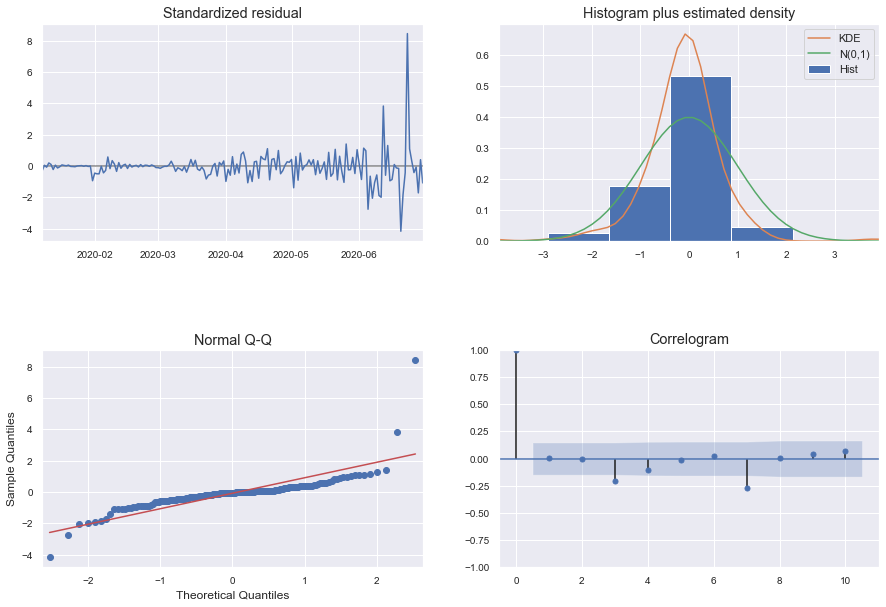

In [52]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

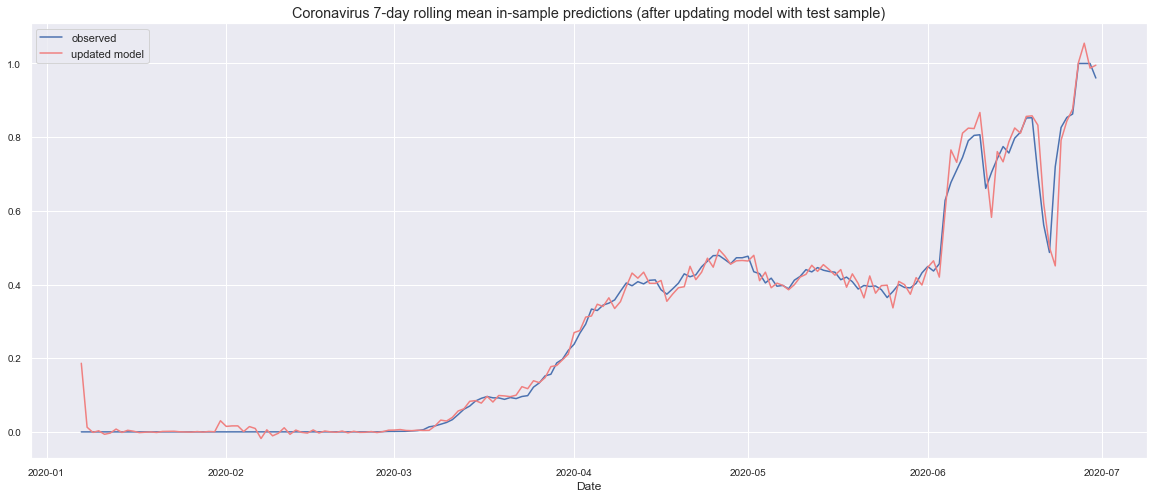

In [53]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [54]:
# Save model again, after updating it with test sample:
#filename = './SpainSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(res_updated, filename)

['./SwedenSARIMAXmodel2.pkl']

# Perform forecast

In [55]:
exog_forecast = exogenous.loc['2020-06-24':'2020-07-07', exogenous.columns.str.contains(country)]
exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')] = \
                   exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')]\
                  .shift(7, fill_value=exog_forecast.loc['2020-06-24':'2020-06-30', exog_forecast.columns.str.contains('Flights')])
exog_forecast = exog_forecast.iloc[1:, :]

exog_forecastR = exog_forecast.rolling(7).mean().dropna()
exog_forecastR

,schoolclosing_Sweden,workplaceclosing_Sweden,cancelpublicevents_Sweden,restrictionsongatherings_Sweden,closepublictransport_Sweden,stayathomerequirements_Sweden,domestictravel_Sweden,internationaltravel_Sweden,publicinfocampaign_Sweden,testingpolicy_Sweden,contacttracing_Sweden,mask_Sweden,FlightsArr_Sweden
2020-07-01,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-02,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-03,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-04,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-05,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-06,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429
2020-07-07,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,6.0,80.571429


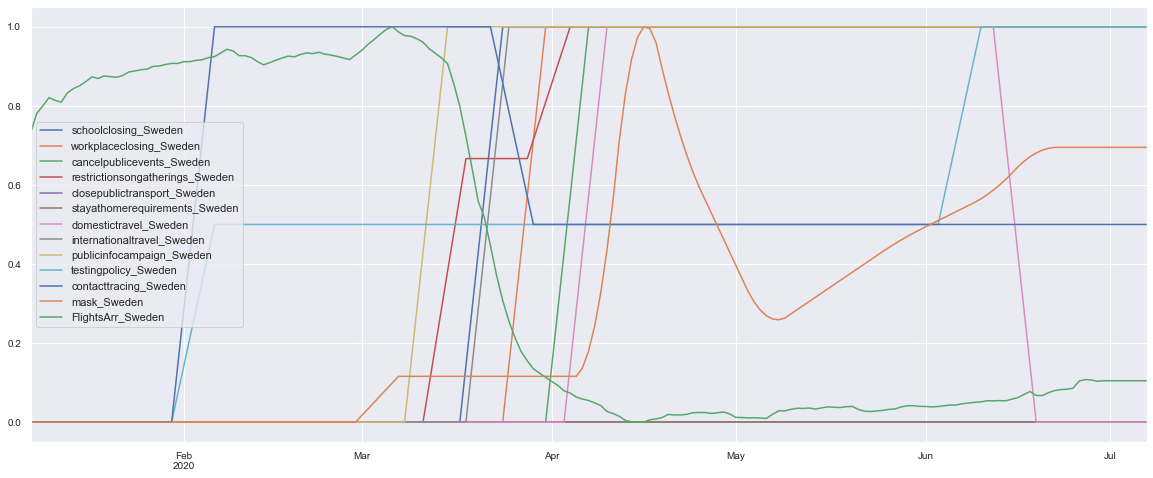

In [56]:
exog_conc = pd.concat([exogenous_ctryR, exog_forecastR])
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.93543947 0.89953933 0.89418413 0.8747139  0.86926726 0.86774361
 0.86731738]


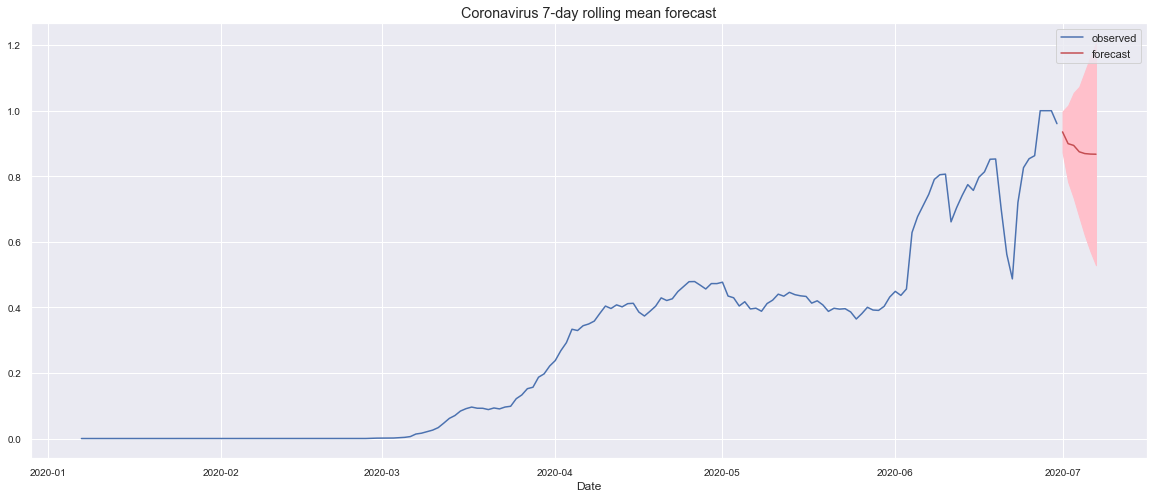

In [57]:
# Generate out of sample forecast
forecast = res_updated.get_forecast(steps=7, exog=X_fc['2020-07-01':'2020-07-07'])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()